# Forecasting Mini-Course Sales

# <a name="0.0"></a>Содержание:
1. [Описание признаков](#1.)
2. [Подготовка датасета](#2.)
    - [Импорт библиотек](#2.1)
    - [Загрузка данных](#2.2)
3. [Общая информация](#3.)
4. [Исследовательский анализ](#4.)
    - [Распределение продаж](#4.1)
    - [Продажи во времени](#4.2)
    - [Стационарность данных](#4.3)
    - [Корреляция и автокорреляция данных (ACF)](#4.4)
5. [Подготовка данных](#5.)
    - [Метрика](#5.1)
    - [Feature engineering](#5.2)
    - [Кодирование категориальных признаков](#5.3)
    - [Разбиение на выборки](#5.4)
6. [Модели](#6.)
    - [LightGBM](#6.1.)
    - [CatBoost](#6.2.)
    - [Сравнение результатов](#6.3.)
    - [Проверка на тестовых данных](#6.4.)
    - [Проверка модели на адекватность](#6.5.)
7. [Вывод](#7.)

<a name="1."></a>
## Описание признаков
<font size="2">([к содержанию](#0.0))</font>

- **id:** уникальный номер события;
- **date:** дата продажи продукта, в формате гг.мм.дд;
- **country:** страна;
- **store:** магазин;
- **product:** продукт.
- **num_sold:** количество проданных продуктов в день

<a name="2."></a>
## Подготовка датасета
<font size="2">([к содержанию](#0.0))</font>

<a name="2.1"></a>
### Импорт библиотек
<font size="2">([к содержанию](#0.0))</font>

In [1]:
# Основные библиотеки для работы с данными и визуализации
import logging
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Cursor
import seaborn as sns
import numpy as np

# Отключение предупреждений
import warnings
warnings.filterwarnings("ignore")

# Библиотеки для анализа временных рядов
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Подготовка данных
from sklearn.model_selection import train_test_split

# Модели машинного обучения
from catboost import CatBoostRegressor
import lightgbm as lgb
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from sklearn.dummy import DummyRegressor

# Дополнительные библиотеки для работы с моделями и оценки производительности
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import make_scorer

<a name="2.2"></a>
### Загрузка данных
<font size="2">([к содержанию](#0.0))</font>

In [2]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

try:
    train = pd.read_csv('train.csv')
    test_df = pd.read_csv('test.csv')
    logger.info('File load: Success')
except FileNotFoundError:
    logger.error('File load: Files not found')
except Exception as e:
    logger.error(f'File load: An error occurred - {e}')

INFO:__main__:File load: Success


<a name="3."></a>
## Общая информация
<font size="2">([к содержанию](#0.0))</font>

In [3]:
train.head()

,id,date,country,store,product,num_sold
0,0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63
1,1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66
2,2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9
3,3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59
4,4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136950 entries, 0 to 136949
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        136950 non-null  int64 
 1   date      136950 non-null  object
 2   country   136950 non-null  object
 3   store     136950 non-null  object
 4   product   136950 non-null  object
 5   num_sold  136950 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 6.3+ MB


Удалим признак `id` так как он не несёт полезной информации

In [5]:
train.drop('id', axis=1, inplace=True)

In [6]:
train.describe()

,num_sold
count,136950.000000
mean,165.522636
std,183.691575
min,2.000000
25%,46.000000
50%,98.000000
75%,184.000000
max,1380.000000


Проверка данных на монотонность (сохраняется ли определенная упорядоченность или направление в последовательности данных). Вернёт 'True' если данные монотонны

In [7]:
train.index.is_monotonic

True

**Вывод:** В датасете train имеем 136950 записей, пропусков в признаках нет. По целевому признаку, что среднее количество продаж составляет 165,52 продукта, а 50% процентиль (медиана) - 98. Это может означать некий дисбаланс распределения. Минимальное и максимальное значение равны 2 и 1380 продаж соответственно. Так же определили, что данные являются монотонными.

<a name="4."></a>
## Исследовательский анализ
<font size="2">([к содержанию](#0.0))</font>

<a name="4.1"></a>
### Распределение продаж
<font size="2">([к содержанию](#0.0))</font>

Построим график распределения целевого признака

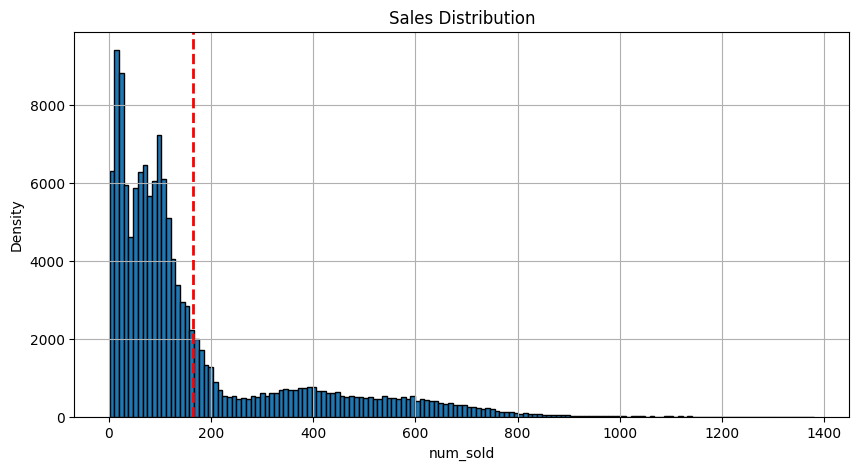

In [8]:
# Построение гистограммы распределения
plt.figure(figsize=(10, 5))
plt.hist(train['num_sold'], bins=150, edgecolor='k') 
plt.axvline(train['num_sold'].mean(), color='red', linestyle='dashed', linewidth=2) # среднее значение
plt.xlabel('num_sold')
plt.ylabel('Density')
plt.title('Sales Distribution')
plt.grid(True)
plt.show()

На графике видим явный дисбаланс продаж - большое количество магазинов делает до 200 продаж, меньшее - в пределах от 200 до 800, и крайне мало - от 800 до 1400. 

<a name="4.2"></a>
### Продажи во времени
<font size="2">([к содержанию](#0.0))</font>

In [9]:
# Преобразование столбца 'date' в формат даты
train['date'] = pd.to_datetime(train['date'])

Установим признак 'date' в качестве индекса DataFrame

In [10]:
train.set_index('date', inplace=True)

In [11]:
def plot_sales_over_time(data, x_col, y_col, hue_col=None, err_style=None, title=None):

    sns.set(style='whitegrid') # стиль белые сетки на белом фоне
    plt.figure(figsize=(15,6), dpi=150) # размер и разрешение
    sns.lineplot(data=data, x=x_col, y=y_col, hue=hue_col, err_style=err_style)
    plt.title(title)
    plt.show()

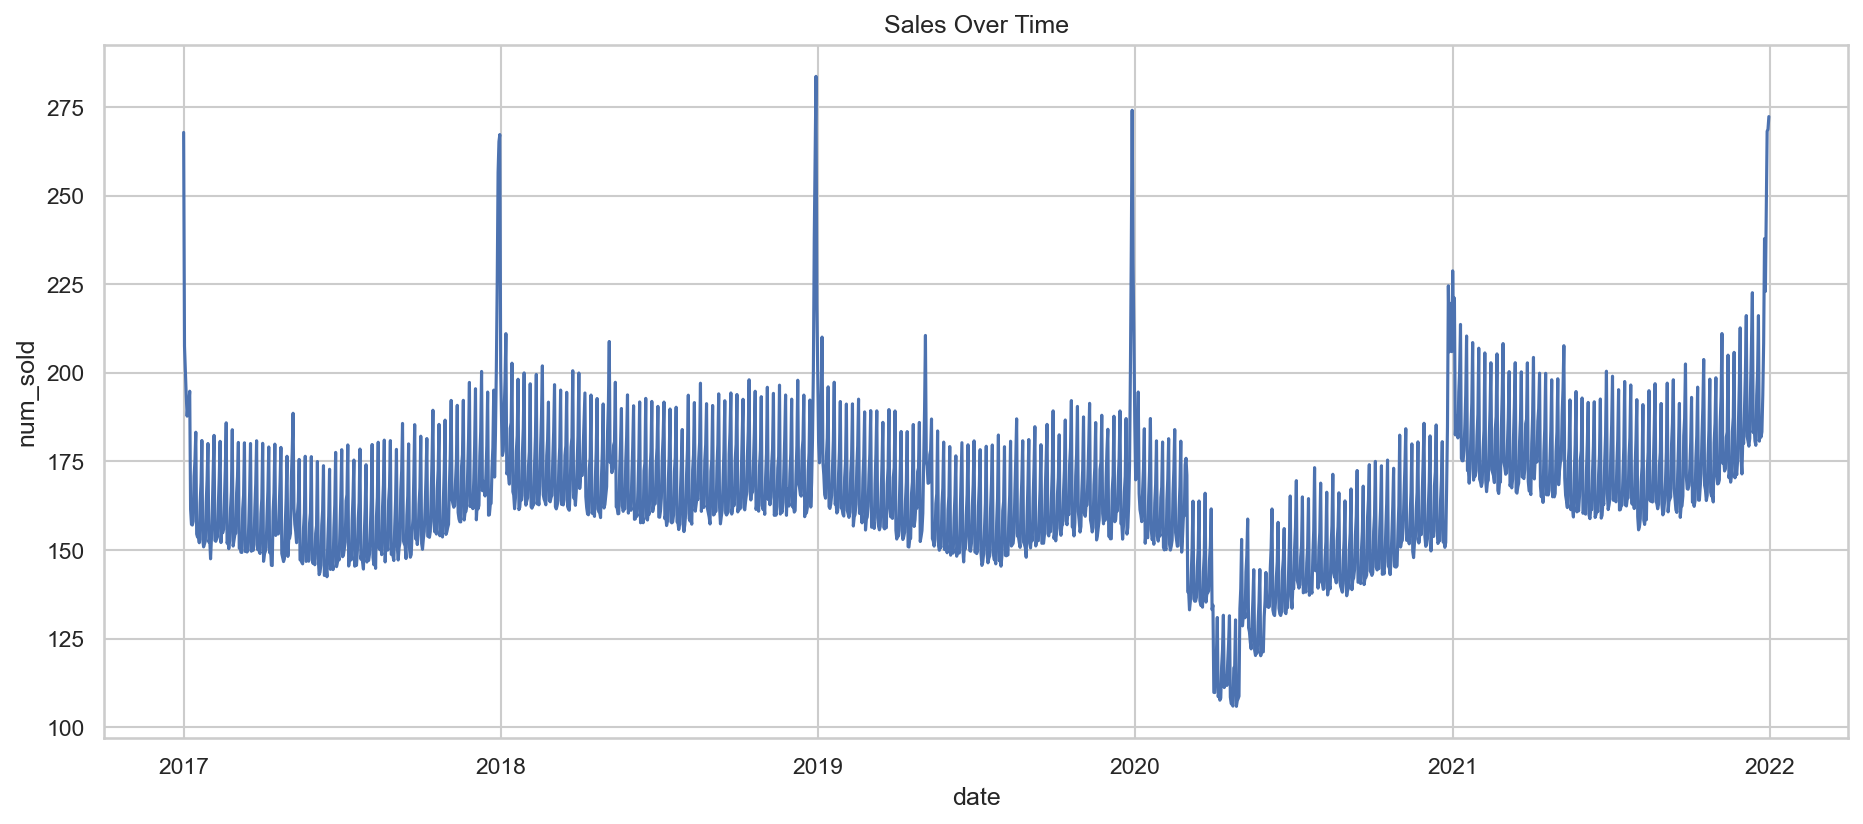

In [12]:
plot_sales_over_time(train, x_col='date', y_col='num_sold', title='Sales Over Time')

1. По графику видим резкие скачки продаж к концу года и такой же резкий спад к началу следующего. Скорей всего это связано с праздничными днями во всем мире - Рождество и Новый год. Эти праздники празднуют в большенстве стран мира;
2. Примерно в апреле-мае каждого кода есть локальные максимумы. Точное появление таких всплесков пока определить не можем. Самый явный скачок виден в 2019 году;
3. 2020 год - аномальный год. Максимальное количество ограничений связанное с COVID-19 как раз наступило в первой половине 2020 года.
4. Так же наблюдается повышение средних показателей продаж в 2021 году. Возможно это последствия карантинных ограничений прошлого года - люди стали больше покупать.

Далее построим графики распределения продаж по странам, по магазинам и по продуктам

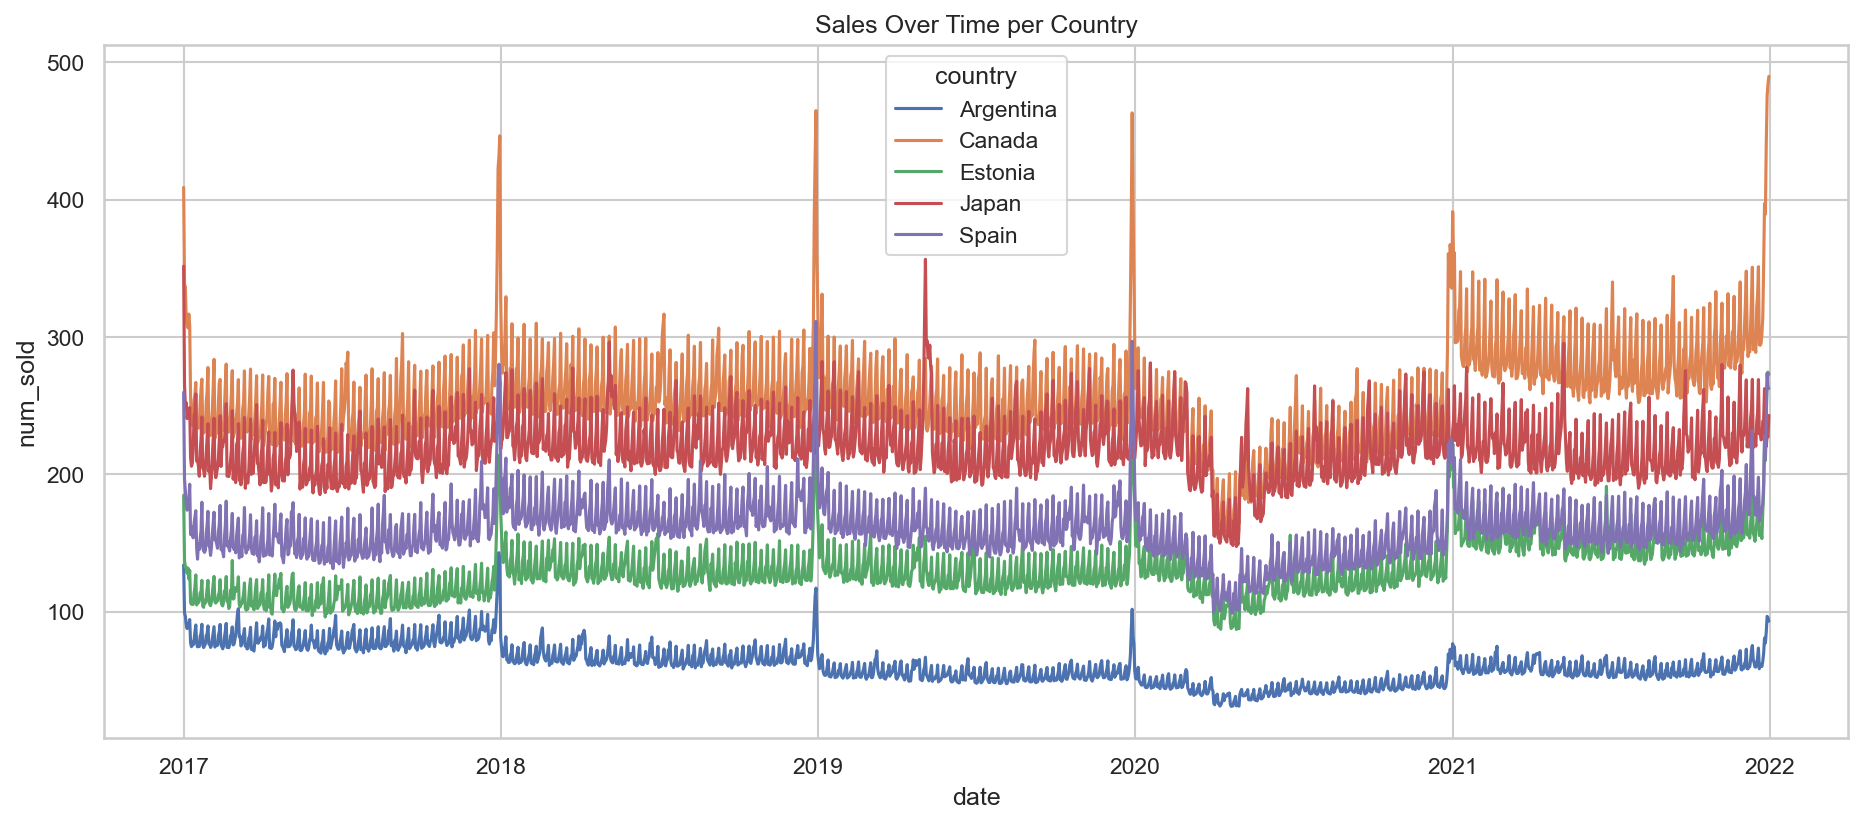

In [13]:
# Начнём с графика распределения продаж по странам
plot_sales_over_time(train, x_col='date', y_col='num_sold', hue_col='country', title='Sales Over Time per Country')

1. По продажам страны можно расположить в таком порядке по мере убывания продаж: Канада, Япония, Испания, Эстония и Аргентина;
2. Наименьшая просадка продаж из-за COVID-19 наблюдается у Аргентины. Так же у нее виден нисходящий тренд начиная с 2018 года, который будет идти в течение 3-х лет, вплоть до начала 2021;
3. Самые высокие просадки в продажах от COVID-19 наблюдаюся у Канадыи и Японии;
4. Локальный максимум в апреле-мае, который мы обнаружили на предыдущей графике происходит только от одной страны - Японии. Скорей всего наши преположения о праздничнах днях являются правдоподобными.

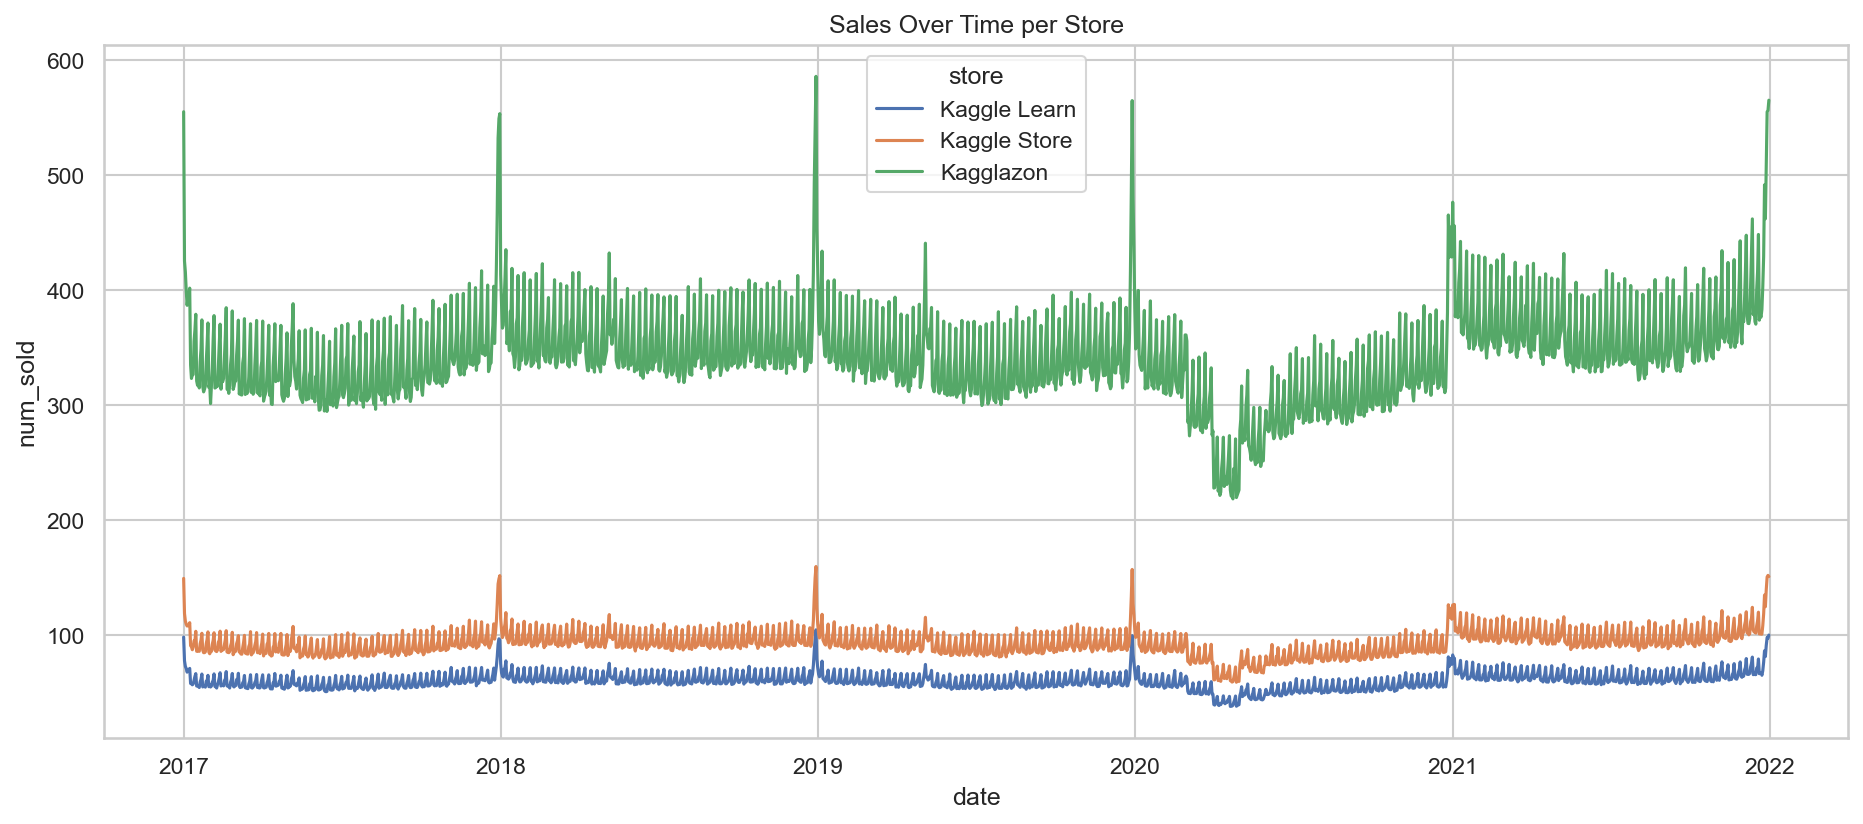

In [14]:
# График распределения продаж по магазинам
plot_sales_over_time(train, x_col='date', y_col='num_sold', hue_col='store', title='Sales Over Time per Store')

1. Наибольшее число продаж наблюдается в `Kagglazon`, за ним идет `Kaggle Store` и наконец `Kaggle Learn` замыкает эту тройку. Два последних магазина идут почти в ровень друг с другом.

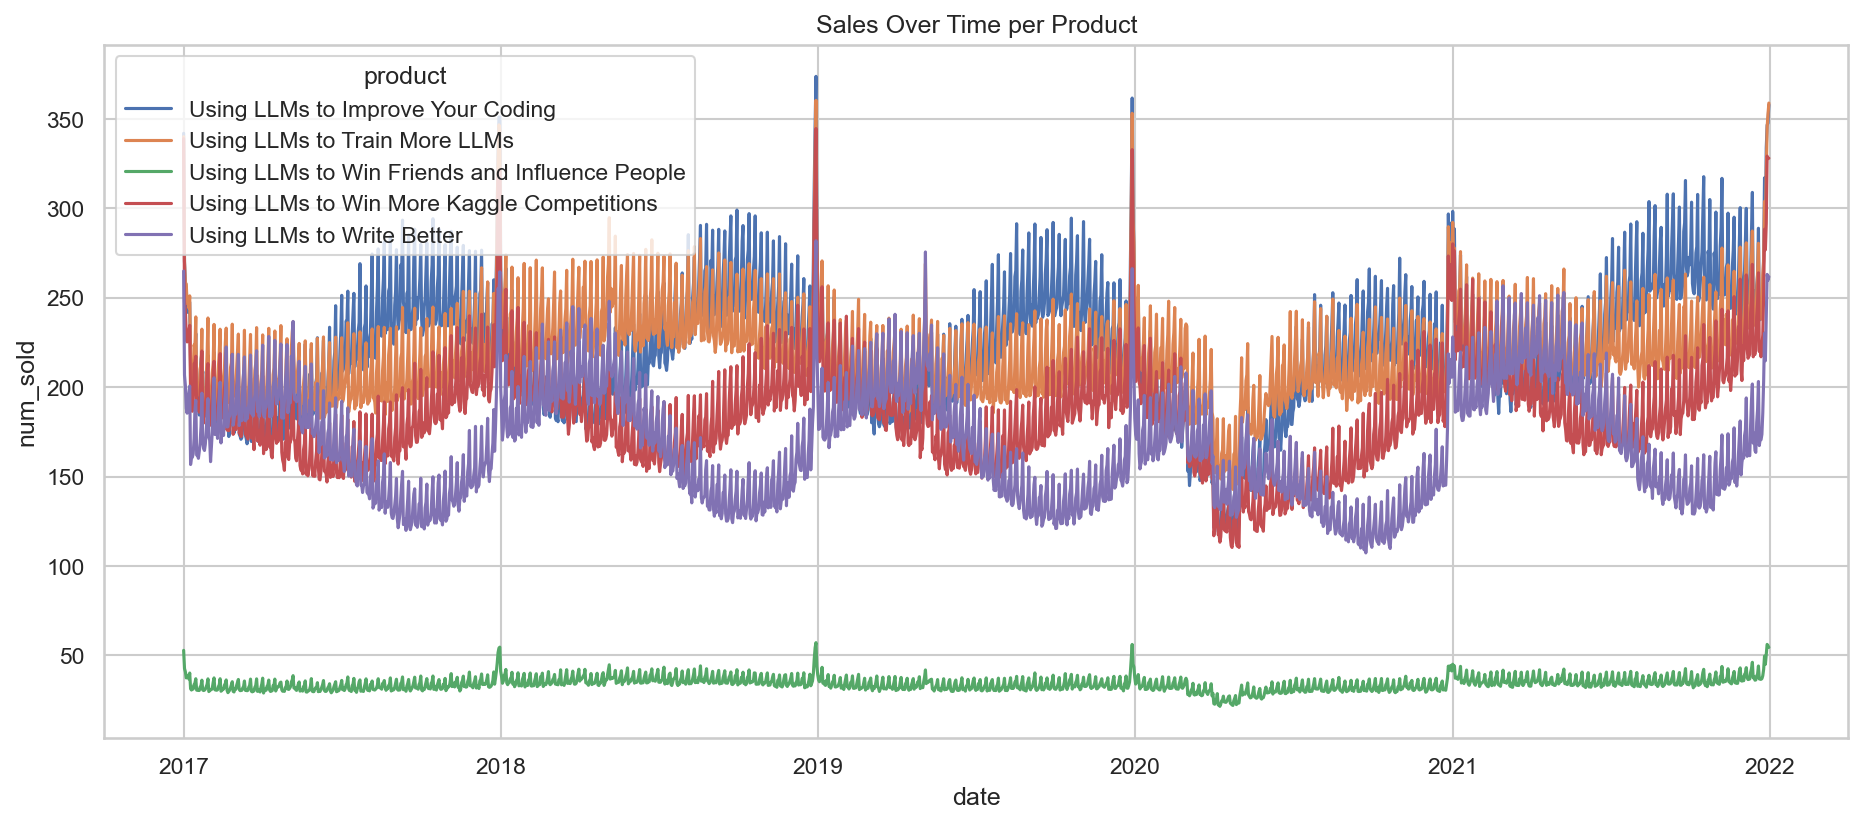

In [15]:
# График распределения продаж по продуктам
plot_sales_over_time(train, x_col='date', y_col='num_sold', hue_col='product', title='Sales Over Time per Product')

1. На фоне всех продуктов `... Win Friends and Influence Peopl` имеет низкий спрос на протяжение всего периода исследования;
2. У остальных продуктов наблюдается сезонность спроса. Но все продукты в той или иной степени имеют высокий спрос на стыке нового года. 

<a name="4.3"></a>
### Стационарность данных
<font size="2">([к содержанию](#0.0))</font>

Для данного исследования воспользуемся статистическим методом исследования, таким как тест Дики-Фуллера.

При проведении теста на стационарность (например, тест Дики-Фуллера), нулевая гипотеза (H0) обычно формулируется так, чтобы предполагать наличие единичных корней, что указывает на нестационарность временного ряда. Альтернативная гипотеза (H1) предполагает отсутствие единичных корней, что свидетельствует о стационарности временного ряда.

Затем проводится статистический тест (ADF-тест), и на основе полученного p-value принимается решение относительно нулевой гипотезы. Если p-value меньше или равно выбранному уровню значимости (в нашем случае, alpha=0.05), то нулевая гипотеза отвергается в пользу альтернативной, что может свидетельствовать о стационарности временного ряда. В противном случае, если p-value больше выбранного уровня значимости, нулевая гипотеза не отвергается, что может указывать на нестационарность временного ряда.

**Нулевая гипотеза (H0):**  
Гипотеза о нестационарности ряда: есть единичные корни (ряд нестационарен).

**Альтернативная гипотеза (H1):**  
Гипотеза о стационарности ряда: нет единичных корней (ряд стационарен).

In [16]:
# Формулируем гипотезы
null_hypothesis = 'Гипотеза о нестационарности ряда: есть единичные корни (ряд нестационарен)'
alternative_hypothesis = 'Гипотеза о стационарности ряда: нет единичных корней (ряд стационарен)'
print(null_hypothesis)
print(alternative_hypothesis)
print()

result = adfuller(train['num_sold'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical values:')
for key, value in result[4].items():
    print('\t {}: {}'.format(key, value))

# Оцениваем гипотезу на основе p-value
alpha = 0.05  # Уровень значимости
if result[1] <= alpha:
    print("\nОтвергаем нулевую гипотезу. Ряд стационарен.")
else:
    print("\nНе отвергаем нулевую гипотезу. Ряд нестационарен.")

Гипотеза о нестационарности ряда: есть единичные корни (ряд нестационарен)
Гипотеза о стационарности ряда: нет единичных корней (ряд стационарен)

ADF Statistic: -11.183076035748277
p-value: 2.4731599364613773e-20
Critical values:
	 1%: -3.430397776254718
	 5%: -2.861561116418768
	 10%: -2.5667812395198735

Отвергаем нулевую гипотезу. Ряд стационарен.


Исходя из этих результатов, можно заключить, что временной ряд является стационарным на уровне значимости 1% и даже строже. Это означает, что у нас есть достаточно статистических доказательств для того, чтобы считать временной ряд стационарным, и мы можем использовать стационарные модели или методы анализа для этого ряда.

- ADF Statistic: -11.183076035748277 - Это зaначение статистики теста. Чем ближе это значение к критическим значениям, тем сложнее принять решение;
- P-value 2.4731599364613773e-20 крайне мало, что указывает на высокую степень уверенности в отвержении нулевой гипотезы. Если p-value меньше или равно какому либо уровню значемости (Critical values), то нулевая гипотеза о нестационарности ряда отвергается, и ряд считается стационарным;
- Critical values (критические значения): Эти значения используются для сравнения с ADF Statistic и определения, можно ли отвергнуть нулевую гипотезу.

Тест сравнивает ADF Statistic с этими критическими значениями при разных уровнях значимости (1%, 5%, 10%).

<a name="4.4"></a>
### Корреляция и автокорреляция данных (ACF)
<font size="2">([к содержанию](#0.0))</font>

Статистическая Корреляция характеризует силу связи между двумя Переменными (в нашем случае между целевым признаком и дургими признаками).  
Коэффициент корреляции Пирсона представляет собой число от -1 до 1, которое описывает прямую или обратную корреляцию соответственно. Нулевое значение указывает на отсутствие таковой. 

In [17]:
# Вычислим матрицу корреляции Пирсона
correlation_matrix = train.corr()
correlation_matrix

,num_sold
num_sold,1.0


Автокорреляция (AutoCorrelation Function, ACF) - это статистическая мера для измерения степени линейной зависимости между значениями внутри одного и того же временного ряда в разные моменты времени. Она позволяет определить, есть ли корреляция между текущим значением временного ряда и его предыдущими значениями на различных лагах (задержках).

Графически ACF представляется в виде коррелограммы, где по горизонтальной оси отложены лаги (задержки), а по вертикальной оси - значения автокорреляции. 

АCF мы будем использовать для подбора гиперпараметров модели временных рядов - ARIMA. ACF поможет определить порядок авторегрессии (p) и порядок скользящего среднего (q).

Основные свойства ACF:
- ACF колеблется между -1 и 1;
- ACF при лаге 0 всегда равна 1 (автокорреляция с самим собой);
- Если ACF на каком-то лаге значительно отличается от нуля, это может указывать на наличие структуры в данных (сезонность, тренд, цикличность);
- Знак автокорреляции указывает на направление зависимости.

Дополнительную информацию можно прочитать на этом сайте: [ссылка](https://www.helenkapatsa.ru/chastichnaia-avtokorrieliatsiia/)

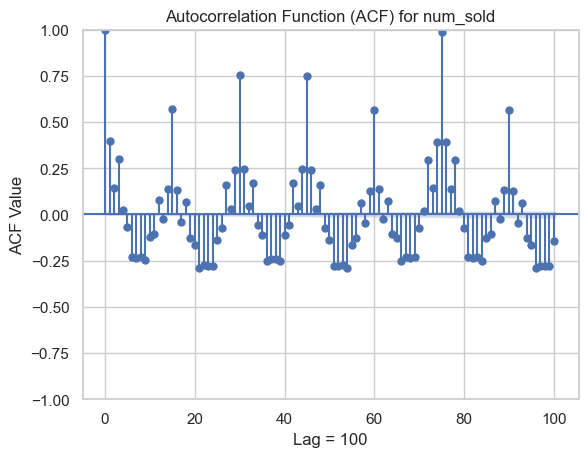

In [18]:
# Вычислим ACF
acf_plot = plot_acf(train['num_sold'], lags=100)
plt.title('Autocorrelation Function (ACF) for num_sold')
plt.xlabel('Lag = 100')
plt.ylabel('ACF Value')
plt.show()

Частичная автокорреляция (Partial Autocorrelation) — это краткая характеристика взаимосвязи между наблюдением во временном ряду и наблюдениями на предыдущем отрезке времени, когда влияние малой задержки устранено.

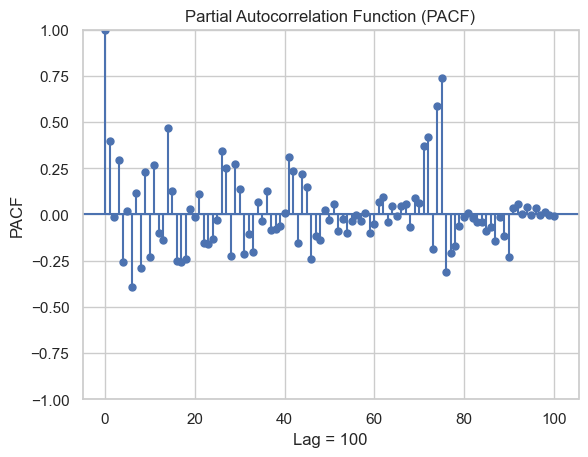

In [19]:
# Строим график PACF
pacf_values = plot_pacf(train['num_sold'], lags=100)
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag = 100')
plt.ylabel('PACF')
plt.show()

На графике ACF (коррелограмме) каждый лаг равен одному дню. По данному коррелограмме видим, что пики автокорреляции, которые достигают значения 1 на лагах 0, 75, 150, 225, 300 и тд. Это может указывать на наличие сезонных или циклических паттернов в ваших данных. Так же у нас присутствует как прямая так и обратная зависимости, при этом обратаная зависимость не привышает значение в -0.3. 

Определение порядока авторегрессии (p) и порядка скользящего среднего (q) в модели ARIMA с помощью ACF и PACF представляет собой сложную задачу в наших данных, так как ACF и PACF постоянно пересекает границу доверительного интервала. Следовательно мы будем проверять эти гиперпараметры по сетке перебора.

<a name="5."></a>
## Подготовка данных
<font size="2">([к содержанию](#0.0))</font>

<a name="5.1"></a>
### Метрика
<font size="2">([к содержанию](#0.0))</font>

В данном соревнование будем использовать метрику SMAPE - симметричное среднее абсолютное процентное отклонение. Это метрика оценки точности прогнозов в задачах регрессии и временных рядов. Она измеряет процентное отклонение между фактическими и прогнозными значениями и учитывает симметричность этого отклонения. SMAPE = 0 означает идеальное совпадение прогнозируемых и фактических значений.

$$
\text{SMAPE} = \frac{100}{n} \sum_{t=1}^{n} \frac{|F_t - A_t|}{(|A_t| + |F_t|)/2}
$$

$n$ - количество наблюдений (наблюдаемые точки)  
$F_t$ - прогнознозируемое значение в момент времени $t$  
$A_t$ - фактическое значение в момент времени $t$  

In [20]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

<a name="5.2"></a>
### Feature engineering
<font size="2">([к содержанию](#0.0))</font>

1. Создадим новые признаки, связанные с датой и временем: извлекаем год, месяц, день и день недели из индекса датафрейма;
2. Создадим скользящую среднюю: это значение представляет собой среднее значение 'num_orders' на предыдущем временном интервале и может помочь сгладить шум и выявить общие тренды в данных. Скользящея среднея для значений 'num_sold', которое сдвинуто на одну позицию вперед (то есть, среднее значение будет находиться для предыдущих 10 точек);
3. Создадим лаги (задержеки): в цикле создаем лаги признака 'num_sold' на разные временные интервалы (1 день, 2 дня и так далее до 30-го дня). Эти лаги представляют значения 'num_sold' на предыдущих временных отрезках. То есть модель может видеть какие значения 'num_sold' предшествовали перед этим значением;
4. Создадим Фурье-признаки: идея использования синуса и косинуса заключается в том, что они предоставляют компактное представление циклических паттернов, позволяя моделировать сезонные колебания данных;
    - month_sin и month_cos: Эти признаки используются для представления месяца (month) в виде синусной (sin) и косинусной (cos) функций. Это позволяет учесть циклические изменения, связанные с месяцами в году. Синус и косинус используются для кодирования сезонных паттернов;
    - day_sin и day_cos: Эти признаки аналогичны предыдущим, но они представляют день месяца (day) с использованием синусной и косинусной функций. Опять же, это помогает учесть циклические изменения внутри месяца.
5. Так как у нас достаточно много событий в датасете то мы можем позволить себе удалить события, в которых содержится NaN, вместо того, чтобы заполнять их какими-либо методами.

In [21]:
data = train.copy()

In [22]:
# Временные признаки
data['year'] = data.index.year
data['month'] = data.index.month
data['day'] = data.index.day
data['dayofweek'] = data.index.dayofweek

# Скользящая средняя
data['rolling_mean'] = data['num_sold'].shift().rolling(10).mean()

# Лаги
for lag in range(1, 30):
    data['lag_{}'.format(lag)] = data['num_sold'].shift(lag)

# Фурье-признаки
data['month_sin'] = np.sin(2*np.pi*data.month/12)
data['month_cos'] = np.cos(2*np.pi*data.month/12)
data['day_sin'] = np.sin(2*np.pi*data.day/31)
data['day_cos'] = np.cos(2*np.pi*data.day/31)

# Удаляем значения с NaN
data.dropna(inplace=True)

<a name="5.3"></a>
### Кодирование категориальных признаков
<font size="2">([к содержанию](#0.0))</font>

У некоторых алгоритмов нет встроенной работы с категориальными данными, следовательно нам необходимо провезти предварительную подготовку данных - кодирования категориальных признаков.

In [23]:
columns_to_encode = ['country', 'store', 'product']
encoded_columns = pd.get_dummies(data[columns_to_encode], drop_first=True)

data_encode = pd.concat([data, encoded_columns], axis=1)
data_encode = data_encode.drop(columns=columns_to_encode)

<a name="5.4"></a>
### Разбиение на выборки
<font size="2">([к содержанию](#0.0))</font>

В данной работе мы будем применять кросс-валидацию, следовательно разбивать данные будем только на train и test в пропорциях 85/15.

Проведем разбиение как исходного датасета без кодирования, так и датасета, который подвергся кодированию.

In [24]:
train_data, test_data = train_test_split(data, test_size=0.15, shuffle=False, random_state=13)

y_train = train_data['num_sold']
y_test = test_data['num_sold']

X_train = train_data.drop('num_sold', axis=1)
X_test = test_data.drop('num_sold', axis=1)

print(X_train.shape), print(y_train.shape)
print()
print(X_test.shape), print(y_test.shape)

(116382, 41)
(116382,)

(20539, 41)
(20539,)


(None, None)

Теперь сделаем выборки из кодированного датасета

In [25]:
train_encode, test_encode = train_test_split(data_encode, test_size=0.15, shuffle=False, random_state=13)

y_train_encode = train_encode['num_sold']
y_test_encode = test_encode['num_sold']

X_train_encode = train_encode.drop('num_sold', axis=1)
X_test_encode = test_encode.drop('num_sold', axis=1)

print(X_train_encode.shape), print(y_train_encode.shape)
print()
print(X_test_encode.shape), print(y_test_encode.shape)

(116382, 48)
(116382,)

(20539, 48)
(20539,)


(None, None)

<a name="6."></a>
## Модели
<font size="2">([к содержанию](#0.0))</font>

В данной работе будем применять два алгоритма машинного обучения, основаных на градиентоном бустинге - LightGBM (Microsoft) и CatBoost (Yandex)

---
Разницу между алгоритмами LightGBM и CatBoost можно прочитать [тут](https://habr.com/ru/companies/tochka/articles/751012/) и посомтреть [тут](https://www.youtube.com/watch?v=UYDwhuyWYSo&t=690s).

--- 
В данной работе я буду использовать RandomizedSearchCV.
RandomizedSearchCV  выполняет случайный поиск по заданным гиперпараметрам и оценивает модели на основе кросс-валидации. Задачей этого процесса является нахождение комбинации гиперпараметров, которая дает лучшую оценку метрики (в нашем случае, SMAPE) на тестовых данных. Чем больше n_iter (количество случайных комбинаций), тем больше вероятность нахождения оптимальных гиперпараметров.  
GridSearchCV перебирает все возможные комбинации параметров на кросс-валидации. RandomizedSearchCV сначала создает словарь с несколькими случайно выбранными параметрами из всех переданных значений. Затем алгоритм тестирует отобранные значения на моделях и выбирает лучшие. Первый метод является крайне ресурсозатратным.

---

In [26]:
# Инициализация кросс-валидации TimeSeriesSplit
time_split = TimeSeriesSplit(n_splits=3)

<a name="6.1"></a>
### LightGBM
<font size="2">([к содержанию](#0.0))</font>

**LightGBM** базируется на идее градиентного бустинга, который является ансамблем деревьев решений. Основная идея состоит в том, чтобы комбинировать множество слабых моделей (деревьев) в одну мощную модель. Градиентный бустинг - это метод, который пошагово улучшает модель, минимизируя функцию потерь. Он делает это, вычисляя градиент функции потерь по отношению к прогнозам модели и корректируя прогнозы в направлении уменьшения потерь. Вместо того, чтобы рассматривать каждое значение признака индивидуально, LightGBM создает гистограммы для значений признаков и вычисляет градиенты на основе гистограмм. Это позволяет значительно ускорить обучение модели.

Подробнее прочитать про LightGBM можно прочитать [тут](https://neptune.ai/blog/lightgbm-parameters-guide).

**Гиперпараметры алгоритма LightGBM:**
1. **n_estimators** - этот параметр определяет количество деревьев, которые будут использоваться в ансамбле. Этот гиперпараметр контролирует, сколько раз выполняется итераций бустинга, при каждой из которых строится новое дерево, чтобы улучшить предсказательную способность модели. Как правило, увеличение значения n_estimators приводит к увеличению производительности модели и улучшению ее способности обобщения.;
2. **num_leaves:** определяет максимальное количество листьев в каждом дереве, создаваемом в ансамбле. Этот параметр влияет на сложность каждого дерева и, следовательно, на сложность всей модели. Глубина деревьев также зависит от значения num_leaves. В LightGBM деревья строятся в бинарной структуре, и глубина дерева будет равна log2(num_leaves);
3. **learning_rate:** скорость обучения определяет размер шага, с которым модель корректирует свои прогнозы на каждой итерации обучения. Маленький шаг увеличивает время обучение и повышеат вероятность переобучения, в тоже время большой шаг уменьшает справляется с недостатками предыдущего, но при этом рискует 'проскочить' наилучшее значение;
4. **max_depth:** глубина дерева определяет, насколько "глубоко" каждое дерево может разветвляться и как много решающих правил оно может содержать;
5. **boosting** — этот параметр определяет каким образом выполняется бустинг, то есть как новые деревья добавляются к ансамблю и как они корректируют ошибки предыдущих деревьев
    - **gbdt (Gradient Boosting Decision Tree):**  Это значение по умолчанию и означает использование градиентного бустинга над деревьями решений. В этом режиме LightGBM использует градиенты функции потерь для обучения деревьев и коррекции предсказаний;
    - **rf (Random Forest):**  Этот режим подразумевает, что каждое дерево обучается независимо от других деревьев. Вместо использования градиентов для коррекции предсказаний, он применяет стохастический выбор функций (признаков) для каждого дерева и стохастический выбор обучающих примеров. Это делает LightGBM более устойчивым к переобучению.

In [27]:
# Определим сетку гиперпараметров
param_dist_lgbm = {
    'n_estimators': np.arange(10, 100, 5),
    'num_leaves': np.arange(2, 50, 2),
    'learning_rate': [0.001, 0.05, 0.1, 0.2],
    'max_depth': [None] + list(range(2, 7))
}

# Инициализируем модель LightGBM
model_lgbm = lgb.LGBMRegressor(random_state=13)

# Создаlbv объект RandomizedSearchCV
model_lgbm_rand = RandomizedSearchCV(
    estimator=model_lgbm,
    param_distributions=param_dist_lgbm,
    scoring=make_scorer(smape, greater_is_better=False),
    cv=time_split,
    n_iter=300,  # Количество случайных комбинаций гиперпараметров
    random_state=13,
    verbose=0
)

# Обучение модели
model_lgbm_rand.fit(X_train_encode, y_train_encode)

# Получение лучшей модели из RandomizedSearchCV
best_model_lgbm_rand = model_lgbm_rand.best_estimator_
# Получение значения SMAPE для лучшей модели
best_smape_lgbm_rand = -model_lgbm_rand.best_score_

# Вывод лучших параметров и оценки
print("Лучшие гиперпараметры LightGBM (RandomizedSearchCV):", model_lgbm_rand.best_params_)
print("SMAPE на кросс-валидации LightGBM (RandomizedSearchCV):", best_smape_lgbm_rand)

Лучшие гиперпараметры LightGBM (RandomizedSearchCV): {'num_leaves': 38, 'n_estimators': 80, 'max_depth': 6, 'learning_rate': 0.2}
SMAPE на кросс-валидации LightGBM (RandomizedSearchCV): 9.210490040630775


<a name="6.2"></a>
### CatBoost
<font size="2">([к содержанию](#0.0))</font>

Краткую и полезную информацию о алгоритме CatBoost можно найти [тут](https://neerc.ifmo.ru/wiki/index.php?title=CatBoost)

**CatBoost** — библиотека для градиентного бустинга, главным преимуществом которой является то, что она одинаково хорошо работает «из коробки» как с числовыми признаками, так и с категориальными.

In [28]:
# Определим сетку гиперпараметров
param_dist_cat = {
    'learning_rate': [0.001, 0.05, 0.1, 0.2],
    'depth': range(2, 7),
    'iterations': range(100, 1000, 100)
}

# Определим индексы категориальных признаков (country, store, product)
cat_features_indices = [0, 1, 2]

# Инициализируем модель CatBoostRegressor
model_cat = CatBoostRegressor(random_state=13, verbose=False, cat_features=cat_features_indices)

# Создадим объект RandomizedSearchCV
model_cat_rand = RandomizedSearchCV(
    estimator=model_cat,
    param_distributions=param_dist_cat,
    n_iter=300,
    scoring=make_scorer(smape, greater_is_better=False),
    cv=time_split
)

# Обучим модель
model_cat_rand.fit(X_train, y_train)

# Получим лучшую модель из RandomizedSearchCV
best_model_cat_rand = model_cat_rand.best_estimator_

# Получим значение SMAPE для лучшей модели
best_smape_cat_rand = -model_cat_rand.best_score_

print("Лучшие гиперпараметры:", model_cat_rand.best_params_)
print("SMAPE на кросс-валидации:", best_smape_cat_rand)

Лучшие гиперпараметры: {'learning_rate': 0.1, 'iterations': 900, 'depth': 5}
SMAPE на кросс-валидации: 9.913973500420587


<a name="6.3"></a>
### Сравнение результатов
<font size="2">([к содержанию](#0.0))</font>

In [29]:
# Создаем словарь с результатами
results = {
    'Model': ['LightGBM', 'CatBoost'],
    'Best SMAPE': [
        best_smape_lgbm_rand, 
        best_smape_cat_rand
    ]
}

pd.DataFrame(results).sort_values(by='Best SMAPE')

,Model,Best SMAPE
0,LightGBM,9.210490
1,CatBoost,9.913974


Наблюдаем, что модель LightGBM показала реультат немного лучше, чем CatBoost. Следовательно, будет использовать ее на проверке на тестовых данных.  
Лучшие гиперпараметры для модели LightGBM: num_leaves = 38, n_estimators = 80, max_depth = 6, learning_rate = 0.2.  
Лучший результат SMAPE на тренировочных данных = 9.210490040630775

<a name="6.4"></a>
### Проверка на тестовых данных
<font size="2">([к содержанию](#0.0))</font>

In [30]:
best_model_lgbm = lgb.LGBMRegressor(**model_lgbm_rand.best_params_, random_state=13)
best_model_lgbm.fit(X_train_encode, y_train_encode)
y_pred_test_lgbm = best_model_lgbm.predict(X_test_encode)
smape_test_lgbm = smape(y_test_encode, y_pred_test_lgbm)
print(f'SMAPE на тестовых данных LightGBM: {smape_test_lgbm}')

SMAPE на тестовых данных LightGBM: 6.856455792055153


SMAPE - это метрика оценки точности модели, которая измеряет процентное отклонение между прогнозами модели и фактическими значениями. Наш SMAPE равен 6.856455792055153, это означает, что средний процент ошибки модели составляет примерно 6.86%.

- Модель совершила ошибку в среднем около 6.86% при прогнозировании значений временного ряда на тестовой выборке;
- Значения, предсказанные моделью, отклоняются от фактических значений на примерно 6.86% в среднем.

Чем ближе значение SMAPE к нулю, тем лучше точность модели. 

<a name="6.5"></a>
### Проверка модели на адекватность
<font size="2">([к содержанию](#0.0))</font>

Для такой проверки сравним нашу лучшую модель с константой моделью Dummy, которая будет предсказывать среднее значение тренировочной выборки

In [31]:
# Создаем константную модель
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(X_train, y_train)
dummy_predictions = dummy_model.predict(X_test)

# Вычислите SMAPE для константной модели
smape_dummy = smape(y_test, dummy_predictions)
print(f'SMAPE константной модели: {smape_dummy}')

SMAPE константной модели: 82.88746563298595


<a name="7."></a>
## Вывод
<font size="2">([к содержанию](#0.0))</font>

В ходе анализа и моделирования временных рядов продаж курсов были сделаны следующие ключевые выводы:

1. Временной ряд продаж курсов имеет ярко выраженные сезонные колебания, связанные с праздниками, такими как Рождество и Новый год, а также локальные пики в апреле-мае, которые могут быть обусловлены другими факторами, требующими дополнительного исследования;

3. Влияние пандемии COVID-19 было отчетливо видно в 2020 году, когда продажи резко снизились в первой половине года. В 2021 году наблюдался повышенный спрос, возможно, из-за карантинных ограничений, влияющих на рынок образования;

4. Анализ продаж по странам показал, что самые высокие продажи наблюдаются в Канаде, Японии, Испании, Эстонии и Аргентине, при этом разные страны реагировали на пандемию COVID-19 по-разному;

5. Среди магазинов наибольшее число продаж приходится на Kagglazon, Kaggle Store и Kaggle Learn;

6. Анализ продаж по продуктам выявил, что продукты имеют различную сезонность и спрос. Например, продукт "How to Win Friends and Influence People" имеет низкий спрос на протяжении всего периода, в то время как другие продукты имеют сезонные колебания и высокий спрос на стыке нового года;

7. Статистический анализ временного ряда продаж позволил убедиться в его стационарности, что позволяет использовать стационарные модели для прогнозирования;

8. Для построения моделей прогнозирования были использованы алгоритмы градиентного бустинга, такие как LightGBM и CatBoost, с оптимизацией гиперпараметров при помощи RandomizedSearchCV;

9. Лучшей моделью, определенной с использованием SMAPE на кросс-валидации, оказалась модель LightGBM с параметрами num_leaves = 38, n_estimators = 80, max_depth = 6 и learning_rate = 0.2;

10. На тестовых данных модель LightGBM показала SMAPE равный 6.86%, что говорит о хорошей точности модели в прогнозировании временного ряда;

11. Сравнение с константной моделью показало, что разработанная модель значительно превосходит случайное предсказание.